# Library and pip install

In [1]:
!pip install datasets
!pip install matplotlib transformers segmentation-models-pytorch torch torchvision
!pip install wandb

# Import libraries
import wandb
wandb.login()

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from datasets import load_dataset
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.transforms import Grayscale
import numpy as np
import segmentation_models_pytorch as smp
from transformers import AutoConfig, AutoModelForImageSegmentation
import torch.nn.functional as F
from sklearn.decomposition import PCA


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 17.2 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=5a40c29158c3723cbb349ecb629eb6085c78994d7a1f8e70a7c4e96c2e000921
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=bcad3c82ce560158d7bd5ae9ba181c9450646448e

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# Load the dataset

In [2]:
# subset_size_train = 1000

# Load the dataset
dataset_full_train = load_dataset('benschill/brain-tumor-collection', split='train')
dataset_full_test = load_dataset('benschill/brain-tumor-collection', split='test')

dataset_train = dataset_full_train
# dataset_train = dataset_full_train.select(range(subset_size_train))
dataset_test = dataset_full_test

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1429: FutureWarning: The repository for benschill/brain-tumor-collection contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/benschill/brain-tumor-collection
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major

Test/root/.cache/huggingface/datasets/downloads/extracted/7aafa170c9a8700e090d9bea81d8e7265fef14341f0329e79184db97321057e2


Generating train split: 0 examples [00:00, ? examples/s]

                                                   file            label
0     /root/.cache/huggingface/datasets/downloads/ex...         No Tumor
1     /root/.cache/huggingface/datasets/downloads/ex...         No Tumor
2     /root/.cache/huggingface/datasets/downloads/ex...         No Tumor
3     /root/.cache/huggingface/datasets/downloads/ex...         No Tumor
4     /root/.cache/huggingface/datasets/downloads/ex...         No Tumor
...                                                 ...              ...
2865  /root/.cache/huggingface/datasets/downloads/ex...  Pituitary Tumor
2866  /root/.cache/huggingface/datasets/downloads/ex...  Pituitary Tumor
2867  /root/.cache/huggingface/datasets/downloads/ex...  Pituitary Tumor
2868  /root/.cache/huggingface/datasets/downloads/ex...  Pituitary Tumor
2869  /root/.cache/huggingface/datasets/downloads/ex...  Pituitary Tumor

[2870 rows x 2 columns]


Generating test split: 0 examples [00:00, ? examples/s]

                                                  file            label
0    /root/.cache/huggingface/datasets/downloads/ex...         No Tumor
1    /root/.cache/huggingface/datasets/downloads/ex...         No Tumor
2    /root/.cache/huggingface/datasets/downloads/ex...         No Tumor
3    /root/.cache/huggingface/datasets/downloads/ex...         No Tumor
4    /root/.cache/huggingface/datasets/downloads/ex...         No Tumor
..                                                 ...              ...
389  /root/.cache/huggingface/datasets/downloads/ex...  Pituitary Tumor
390  /root/.cache/huggingface/datasets/downloads/ex...  Pituitary Tumor
391  /root/.cache/huggingface/datasets/downloads/ex...  Pituitary Tumor
392  /root/.cache/huggingface/datasets/downloads/ex...  Pituitary Tumor
393  /root/.cache/huggingface/datasets/downloads/ex...  Pituitary Tumor

[394 rows x 2 columns]


/usr/local/lib/python3.10/dist-packages/datasets/load.py:1429: FutureWarning: The repository for benschill/brain-tumor-collection contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/benschill/brain-tumor-collection
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [3]:
# Checking the dimensions of the first image in the training dataset
first_image = dataset_train[0]['image']
image_dimensions = first_image.size  # PIL images use size attribute for dimensions

print("Image Dimensions:", image_dimensions)

Image Dimensions: (512, 512)


# Check some images

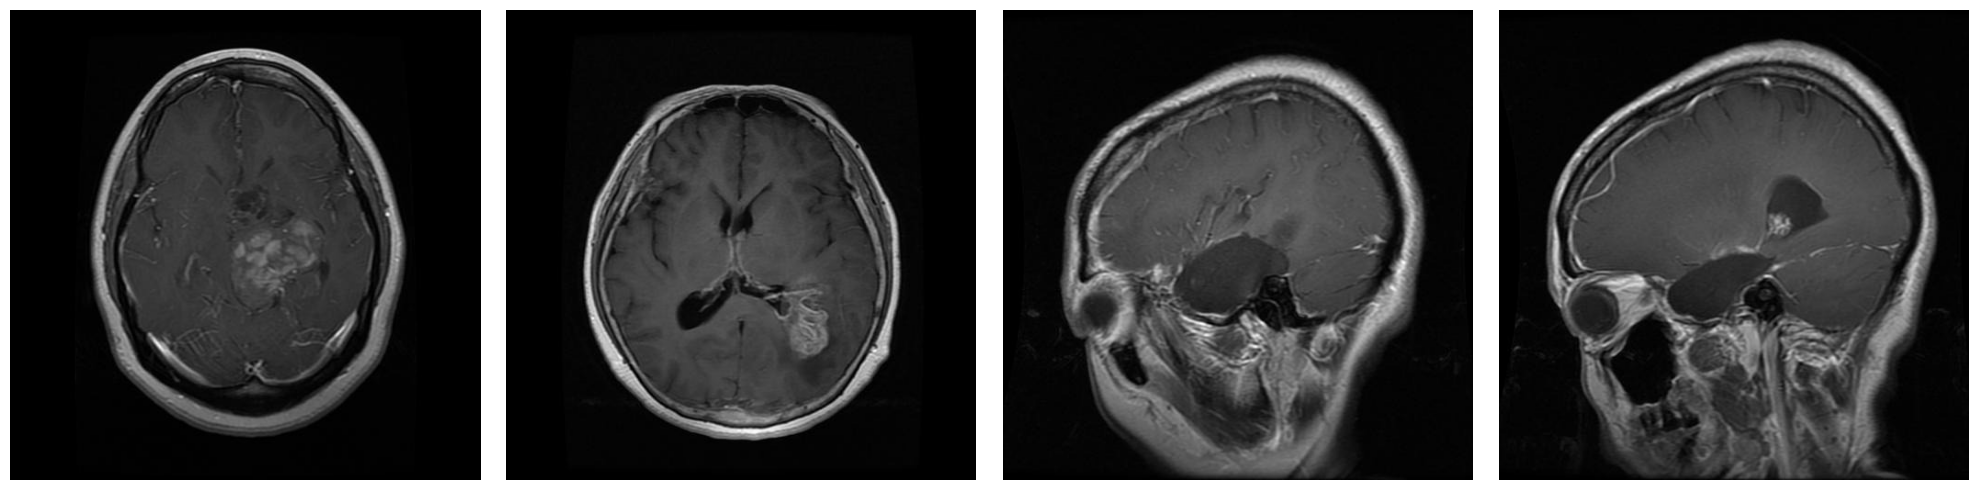

In [4]:
def show_images(images, labels, ncols=4):
    nrows = len(images) // ncols + (len(images) % ncols > 0)
    fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 5 * nrows))
    axes = axes.flatten()

    for i, (image, label) in enumerate(zip(images, labels)):
        axes[i].imshow(image)
        axes[i].axis('off')  # Removed the label for simplicity

    # Hide any unused subplots
    for i in range(len(images), len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Collect the first four images and their labels
images = [dataset_train[i]['image'] for i in range(4)]  # Adjusted to display first four images
labels = [dataset_train[i]['label'] for i in range(4)]

# Display the images side-by-side
show_images(images, labels)


# Data Loader

In [5]:
def get_dataloader(dataset, batch_size=32):
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        Grayscale(num_output_channels=1),
        transforms.ToTensor()
    ])
    dataset = [(transform(img['image']), img['label']) for img in dataset]  # Ensure images are float
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)


# Loss function

In [6]:
# Loss function
def loss_function_VAE(recon_x, x, mu, log_var):
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

# Architecture

In [7]:
class VAE(nn.Module):
    def __init__(self, latent_dim, dropout_rate=0.5):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder Layers
        self.enc_conv1 = nn.Conv2d(1, 32, 3, stride=2, padding=1)
        self.enc_bn1 = nn.BatchNorm2d(32)
        self.enc_conv2 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.enc_bn2 = nn.BatchNorm2d(64)
        self.enc_conv3 = nn.Conv2d(64, 128, 3, stride=2, padding=1)
        self.enc_bn3 = nn.BatchNorm2d(128)
        self.enc_conv4 = nn.Conv2d(128, 256, 3, stride=2, padding=1)
        self.enc_bn4 = nn.BatchNorm2d(256)
        self.enc_conv5 = nn.Conv2d(256, 512, 3, stride=2, padding=1)
        self.enc_bn5 = nn.BatchNorm2d(512)

        self.flatten_size = 512 * 4 * 4
        self.fc_mu = nn.Linear(self.flatten_size, self.latent_dim)
        self.fc_log_var = nn.Linear(self.flatten_size, self.latent_dim)
        self.fc_z = nn.Linear(self.latent_dim, self.flatten_size)

        # Decoder Layers
        self.dec_conv_trans1 = nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1)
        self.dec_bn1 = nn.BatchNorm2d(256)
        self.dec_conv_trans2 = nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1)
        self.dec_bn2 = nn.BatchNorm2d(128)
        self.dec_conv_trans3 = nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1)
        self.dec_bn3 = nn.BatchNorm2d(64)
        self.dec_conv_trans4 = nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1)
        self.dec_bn4 = nn.BatchNorm2d(32)
        self.dec_conv_trans5 = nn.ConvTranspose2d(32, 1, 4, stride=2, padding=1)

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, return_intermediate=True):
        # Encoder
        e1 = F.leaky_relu(self.enc_bn1(self.enc_conv1(x)), 0.01)
        e2 = F.leaky_relu(self.enc_bn2(self.enc_conv2(e1)), 0.01)
        e3 = F.leaky_relu(self.enc_bn3(self.enc_conv3(e2)), 0.01)
        e4 = F.leaky_relu(self.enc_bn4(self.enc_conv4(e3)), 0.01)
        e5 = F.leaky_relu(self.enc_bn5(self.enc_conv5(e4)), 0.01)

        flat = e5.view(-1, self.flatten_size)
        mu = self.fc_mu(flat)
        log_var = self.fc_log_var(flat)
        z = self.reparameterize(mu, log_var)

        # Transforming the latent variable for the decoder
        z = self.fc_z(z)

        # Decoder
        z = z.view(-1, 512, 4, 4)
        d1 = F.leaky_relu(self.dec_bn1(self.dec_conv_trans1(z)), 0.01)
        d2 = F.leaky_relu(self.dec_bn2(self.dec_conv_trans2(d1)), 0.01)
        d3 = F.leaky_relu(self.dec_bn3(self.dec_conv_trans3(d2)), 0.01)
        d4 = F.leaky_relu(self.dec_bn4(self.dec_conv_trans4(d3)), 0.01)
        d5 = torch.sigmoid(self.dec_conv_trans5(d4))

        if return_intermediate:
            return d5, mu, log_var, [e1, e2, e3, e4, e5], [d1, d2, d3, d4]  # Include d5 here
        else:
            return d5

In [ ]:
def define_sweep_config():
    sweep_config = {
        'method': 'bayes',  # or 'grid', 'random'
        'metric': {
            'name': 'loss',
            'goal': 'minimize'
        },
        'parameters': {
            'learning_rate': {
                'values': [1e-3, 5e-4, 1e-4]
            },
            'epochs': {
                'values': [10, 20, 40]
            },
            'batch_size': {
                'values': [16, 32, 64]
            },
            'latent_dim': {
                'values': [512, 1024, 2048]
            }
        }
    }
    return sweep_config

In [9]:
def train_VAE(model, dataloader, optimizer, device, epochs):
    model.to(device)
    model.train()

    for epoch in range(epochs):
        total_loss = 0

        for data in dataloader:
            img, _ = data
            img = img.to(device)
            optimizer.zero_grad()
            recon_batch, mu, log_var, _, _ = model(img)
            loss = loss_function_VAE(recon_batch, img, mu, log_var)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        average_loss = total_loss / len(dataloader)
        print(f"Epoch {epoch+1}, Average Loss: {average_loss}")
        wandb.log({"Epoch": epoch+1, "Average_loss": average_loss})

# Visualization

In [10]:
def visualize_reconstruction(model, dataloader, device, model_name="Model", num_images=5):
    model.eval()
    with torch.no_grad():
        for i, (img, _) in enumerate(dataloader):
            if i == 1:
                img = img.to(device)
                recon = model(img, return_intermediate=False)  # Get only the reconstructed images
                img = img.cpu()
                recon = recon.cpu()

                # Plot original and reconstructed images
                fig, axes = plt.subplots(2, num_images, figsize=(10, 4))
                fig.suptitle(f'{model_name}')  # Adding a title with the model name
                for j in range(num_images):
                    # Display original
                    axes[0, j].imshow(img[j].squeeze(), cmap='gray')
                    axes[0, j].set_title('Original')
                    axes[0, j].axis('off')

                    # Display reconstruction
                    axes[1, j].imshow(recon[j].squeeze(), cmap='gray')
                    axes[1, j].set_title('Reconstructed')
                    axes[1, j].axis('off')
                plt.show()
                break

In [11]:
def visualize_intermediate_layers(model, dataloader, device, num_images=5):
    model.eval()
    with torch.no_grad():
        for img, _ in dataloader:
            img = img.to(device)
            recon, _, _, encoder_layers, decoder_layers = model(img)
            img = img.cpu()
            recon = recon.cpu()

            encoder_layer_names = ['enc_conv1', 'enc_conv2', 'enc_conv3', 'enc_conv4', 'enc_conv5']
            decoder_layer_names = ['dec_conv1', 'dec_conv2', 'dec_conv3', 'dec_conv4']

            # Calculate total number of layers for plotting
            num_layers = len(encoder_layers) + len(decoder_layers) + 2
            fig, axes = plt.subplots(num_layers, num_images, figsize=(10, 2 * num_layers))

            # Display original images
            for j in range(num_images):
                axes[0, j].imshow(img[j].squeeze(), cmap='gray')
                axes[0, j].set_title('Original')
                axes[0, j].axis('off')

            # Display encoder and decoder layer outputs
            for i in range(len(encoder_layers)):
                for j in range(num_images):
                    output = encoder_layers[i][j].detach().cpu()
                    if output.size(0) > 1:
                        output = output.mean(dim=0)
                    axes[i + 1, j].imshow(output.squeeze(), cmap='gray')
                    axes[i + 1, j].set_title(encoder_layer_names[i])
                    axes[i + 1, j].axis('off')

            for i in range(len(decoder_layers)):
                for j in range(num_images):
                    output = decoder_layers[i][j].detach().cpu()
                    if output.size(0) > 1:
                        output = output.mean(dim=0)
                    axes[i + 1 + len(encoder_layers), j].imshow(output.squeeze(), cmap='gray')
                    axes[i + 1 + len(encoder_layers), j].set_title(decoder_layer_names[i])
                    axes[i + 1 + len(encoder_layers), j].axis('off')

            # Display reconstructed images
            for j in range(num_images):
                axes[num_layers - 1, j].imshow(recon[j].squeeze(), cmap='gray')
                axes[num_layers - 1, j].set_title('Reconstructed')
                axes[num_layers - 1, j].axis('off')

            plt.show()
            break  # Only show the first batch

# Main function

In [12]:
def main():
    wandb.init()
    config = wandb.config
    # Check for CUDA availability
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Initialize model and optimizer using W&B config
    latent_dim = wandb.config.latent_dim

    # Model selection
    vae = VAE(latent_dim=latent_dim)  # Removed device argument here
    optimizer = optim.Adam(vae.parameters(), lr=wandb.config.learning_rate)

    # Get data loaders
    train_loader = get_dataloader(dataset_train, batch_size=wandb.config.batch_size)
    test_loader = get_dataloader(dataset_test, batch_size=wandb.config.batch_size)

    # Train the model
    train_VAE(vae, train_loader, optimizer, device, epochs=wandb.config.epochs)

    # Visualize the original and the reconstructed image
    visualize_reconstruction(vae, test_loader, device, model_name="VAE")

    # Visualize intermediate outputs
    visualize_intermediate_layers(vae, test_loader, device)

    # Close the W&B run
    wandb.finish()

In [13]:
if __name__ == "__main__":
    sweep_config = define_sweep_config()
    sweep_id = wandb.sweep(sweep_config, project="UNITN-Project_VAE_Opt_1", entity="yusuke-sugihara")
    wandb.agent(sweep_id, main)

Output hidden; open in https://colab.research.google.com to view.